In [1]:
import os
from pathlib import Path
import pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plot_style_config as psc

In [2]:
psc.set_pub_style()
P = psc.STYLE_PARAMS # 简写引用参数

DATA_DIR = 'data'
SAVE_DIR = 'plots'

In [3]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
def simplify_label(filename):
    """
    自动从文件名提取简短 Label (当没有提供手动 label 时使用)
    """
    name = filename.replace('.csv', '').replace('.pkl', '')
    
    label_parts = []
    if 'uniform' in name:
        label_parts.append('Uniform')
    elif 'heterogeneous' in name:
        label_parts.append('Hetero')
    
    match_n = re.search(r'_n(\d+)_', name)
    if match_n:
        label_parts.append(f"N={match_n.group(1)}")
        
    if not label_parts:
        return name[-15:] 
        
    return " ".join(label_parts)

In [44]:
def convert_beta_to_temp(beta, beta_ref=20, T_ref=293.15):
    '''
    beta是数据中的env_temp,
    beta_ref是参考温度下的beta,
    T_ref是参考温度
    '''
    return T_ref * (beta_ref/beta) - 273.15

In [41]:
def plot(
    target_metric: str, 
    target_filenames: list,  # [修改] 接收文件名列表
    x_label: str,
    y_label: str, 
    title: str,
    xlim: tuple = None,   # 这是一个范围值 (如 (min, max))
    ylim: tuple = None,
    legend_labels: list = None, # [新增] 可选：手动指定图例标签列表
    y_scale: str = 'linear',
    convert_temp: bool = True
):
    """
    通用绘图函数：根据指定的文件列表绘制对比图
    
    Args:
        target_metric (str): CSV/PKL 中的列名 (e.g., 'MC', 'KR')
        target_filenames (list): 要对比的文件名列表 (e.g., ['file1.csv', 'file2.pkl'])
        y_label (str): Y轴标签
        title (str): 图表标题
        ylim (tuple): Y轴范围
        legend_labels (list): 对应文件名的图例名称列表。如果为None，则自动生成。
    """
    ensure_dir(SAVE_DIR)

    # 1. 验证文件是否存在
    valid_files = []
    for f in target_filenames:
        # 支持绝对路径，也支持仅提供文件名(默认在DATA_DIR下)
        if os.path.exists(f):
            valid_files.append(f)
        elif os.path.exists(os.path.join(DATA_DIR, f)):
            valid_files.append(os.path.join(DATA_DIR, f))
        else:
            print(f"  [Warning] File not found: {f}")
    
    if not valid_files:
        print("No valid files found to plot.")
        return

    # 2. 创建画布
    fig_size = psc.get_figsize('single', psc.RATIO_GOLDEN)
    plt.figure(figsize=fig_size)

    # 3. 循环绘图
    for i, file_path in enumerate(valid_files):
        try:
            # 读取数据
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            else:
                df = pd.read_pickle(file_path)
            
            if target_metric not in df.columns:
                print(f"  [Skip] Column '{target_metric}' not found in {os.path.basename(file_path)}")
                continue


            if convert_temp:
                df['temp'] = convert_beta_to_temp(df['temp'])

            if xlim:
                x_min, x_max = xlim
                # 假设 x轴数据列名为 'temp' (根据你的项目上下文)
                if 'temp' in df.columns:
                    # 仅保留在 xlim 范围内的数据
                    df = df[(df['temp'] >= x_min) & (df['temp'] <= x_max)]
                    
                    # 如果筛选后为空，跳过
                    if df.empty:
                        print(f"  [Skip] No data in range {xlim} for {os.path.basename(file_path)}")
                        continue
                else:
                    print(f"  [Warning] Column 'temp' not found, skipping xlim filtering for {file_path}")
            
            
                
            # 确定图例 Label
            if legend_labels and i < len(legend_labels):
                label_text = legend_labels[i]
            else:
                label_text = simplify_label(os.path.basename(file_path))
            
            # 绘图样式
            color = P['color_cycle'][i % len(P['color_cycle'])]
            
            plt.plot(df['temp'], df[target_metric], 
                     marker='o', linestyle='-',
                     color=color,
                     linewidth=P['linewidth_plot'],
                     markersize=P['markersize'],
                     markeredgewidth=P['markeredgewidth'],
                     label=label_text)
            
            
        except Exception as e:
            print(f"  [Error] Reading {file_path}: {e}")

    # 4. 装饰与保存
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    if y_scale == 'log':
        plt.yscale('log')
        
    plt.grid(True, linewidth=P['linewidth_grid'])
    plt.legend(frameon=False, fontsize=P['font_size_legend'])
    
    safe_name = title.replace(" ", "_").replace("/", "").lower()
    save_path = os.path.join(SAVE_DIR, f"{safe_name}_comparison.png")
    
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Saved plot to: {save_path}")

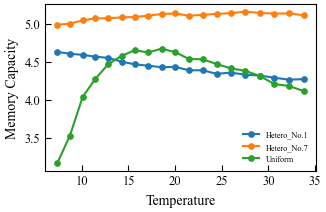

Saved plot to: plots\mc_comparison_uniform_vs_hetero_comparison.png


In [45]:
file = [
    'result_MC_heterogeneous_n5_sr20to30_w0.2-0.28-0.31-0.18-0.02_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_MC_heterogeneous_n6_sr20to30_w0.16-0.2-0.2-0.15-0.1-0.18_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_MC_uniform_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv'
    ]

label = [
    'Hetero_No.1',
    'Hetero_No.7',
    'Uniform'
]

plot(
        target_metric='MC',
        target_filenames=file,  # 传入文件列表
        legend_labels=label,    # 传入图例列表 (可选)
        x_label='Temperature',
        y_label='Memory Capacity',
        title='MC Comparison Uniform vs Hetero'
    )


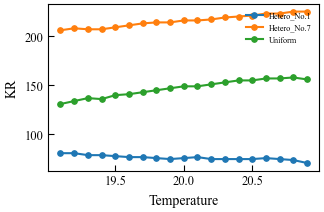

Saved plot to: plots\kr_comparison_uniform_vs_hetero_comparison.png


In [7]:
file = [
    'result_KRandGR_heterogeneous_n5_sr20to30_w0.2-0.28-0.31-0.18-0.02_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_KRandGR_heterogeneous_n6_sr20to30_w0.16-0.2-0.2-0.15-0.1-0.18_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_KRandGR_uniform_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv'
    ]

label = [
    'Hetero_No.1',
    'Hetero_No.7',
    'Uniform'
]

plot(
        target_metric='KR',
        target_filenames=file,  # 传入文件列表
        legend_labels=label,    # 传入图例列表 (可选)
        x_label='Temperature',
        y_label='KR',
        title='KR Comparison Uniform vs Hetero'
    )

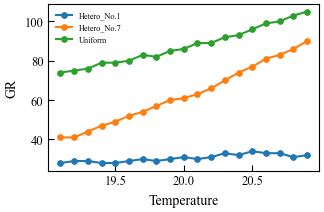

Saved plot to: plots\gr_comparison_uniform_vs_hetero_comparison.png


In [8]:
file = [
    'result_KRandGR_heterogeneous_n5_sr20to30_w0.2-0.28-0.31-0.18-0.02_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_KRandGR_heterogeneous_n6_sr20to30_w0.16-0.2-0.2-0.15-0.1-0.18_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_KRandGR_uniform_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv'
    ]

label = [
    'Hetero_No.1',
    'Hetero_No.7',
    'Uniform'
]

plot(
        target_metric='GR',
        target_filenames=file,  # 传入文件列表
        legend_labels=label,    # 传入图例列表 (可选)
        x_label='Temperature',
        y_label='GR',
        title='GR Comparison Uniform vs Hetero'
    )

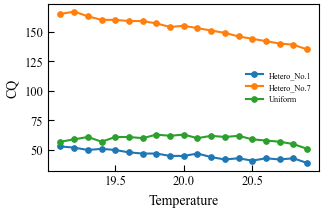

Saved plot to: plots\cq_comparison_uniform_vs_hetero_comparison.png


In [9]:
file = [
    'result_KRandGR_heterogeneous_n5_sr20to30_w0.2-0.28-0.31-0.18-0.02_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_KRandGR_heterogeneous_n6_sr20to30_w0.16-0.2-0.2-0.15-0.1-0.18_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv',
    'result_KRandGR_uniform_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv'
    ]

label = [
    'Hetero_No.1',
    'Hetero_No.7',
    'Uniform'
]

plot(
        target_metric='CQ',
        target_filenames=file,  # 传入文件列表
        legend_labels=label,    # 传入图例列表 (可选)
        x_label='Temperature',
        y_label='CQ',
        title='CQ Comparison Uniform vs Hetero'
    )

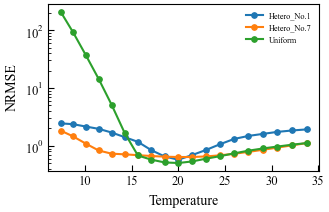

Saved plot to: plots\narma10_comparison_uniform_vs_hetero_comparison.png


In [46]:
file = [
    'result_NARMA10_heterogeneous_n5_sr20to30_w0.2-0.28-0.31-0.18-0.02_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.pkl',
    'result_NARMA10_heterogeneous_n6_sr20to30_w0.16-0.2-0.2-0.15-0.1-0.18_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.pkl',
    'result_NARMA10_uniform_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.pkl'
    ]

label = [
    'Hetero_No.1',
    'Hetero_No.7',
    'Uniform'
]

plot(
        target_metric='NRMSE',
        target_filenames=file,  
        legend_labels=label,    
        x_label='Temperature',
        y_label='NRMSE',
        y_scale='log',
        title='NARMA10 Comparison Uniform vs Hetero',
    )